In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [47]:
data = pd.read_csv('data.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

In [ ]:
class UserLocationDateset(Dataset):
    def __init__(self, data):
        self.data = data
        self.user_ids = data['user_id'].unique()
        self.user2idx = {o:i for i,o in enumerate(self.user_ids)}
        self.item_ids = data['item_id'].unique()
        self.item2idx = {o:i for i,o in enumerate(self.item_ids)}
        self.n_users = len(self.user_ids)
        self.n_items = len(self.item_ids)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        user_id = self.data.iloc[idx]['user_id']
        item_id = self.data.iloc[idx]['item_id']
        rating = self.data.iloc[idx]['rating']
        return self.user2idx[user_id], self.item2idx[item_id], rating

dset = UserLocationDateset(data)

In [45]:
dl = DataLoader(dset, batch_size=64, shuffle=True)
next(iter(dl))

NameError: name 'DataLoader' is not defined

In [ ]:
class CollabFilter(nn.Module):
    def __init__(self, n_users, n_items, n_factors=50):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        items = self.item_factors(x[:,1])
        return (users * items).sum(1)

def get_model(data, n_factors):
    n_users = data.userId.nunique()
    n_items = data.movie_idx.nunique()
    model = CollabFilter(n_users, n_items, n_factors)
    return model

net = get_model(data, 50)

In [ ]:
bs = 64
train_dl = DataLoader(dset, batch_size=bs, shuffle=True)
opt = torch.optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
n_epochs = 10

for epoch in range(n_epochs):
    net.train()
    for xb, yb in train_dl:
        loss = F.mse_loss(net(xb), yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    lr_scheduler.step()
    print(loss)

def get_predictions(model, data):
    model.eval()
    users, items, ratings = data
    users = torch.LongTensor(users)
    items = torch.LongTensor(items)
    predictions = model(torch.stack([users, items], dim=1))
    return predictions.detach().numpy()

def get_top_k_items(predictions, k=10):
    top_k = np.argpartition(predictions, -k)[-k:]
    return top_k[np.argsort(predictions[top_k])][::-1]

## Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
flight_df = pd.read_csv('flights.csv', index_col=0)
user_df = pd.read_csv('users.csv', index_col=0)
hotels_df = pd.read_csv('hotels.csv', index_col=0)

In [17]:
# there is 1340 users, 135944 flights, and 40552 hotels
len(user_df.index.unique()), len(flight_df.index.unique()), len(hotels_df.index.unique())
user_df.head()

,company,name,gender,age
code,,,,
0,4You,Roy Braun,male,21
1,4You,Joseph Holsten,male,37
2,4You,Wilma Mcinnis,female,48
3,4You,Paula Daniel,female,23
4,4You,Patricia Carson,female,44


Text(0.5, 0, 'age')

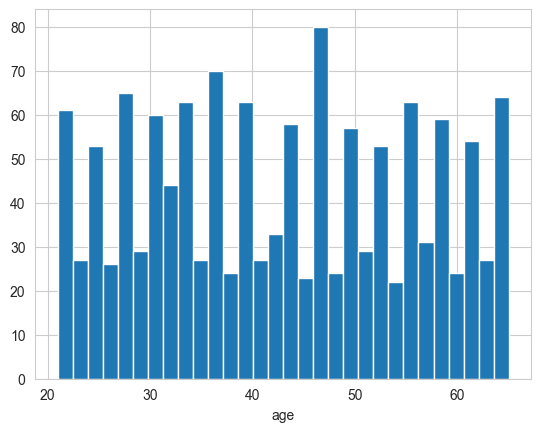

In [18]:
sns.set_style('whitegrid')
user_df['age'].hist(bins=30)
plt.xlabel('age') # the age is not normally distributed

In [23]:
# join user_df with flight_df
flight_user_df = flight_df.join(user_df, on='userCode')
flight_user_df.head()

,userCode,from,to,flightType,price,time,distance,agency,date,company,name,gender,age
travelCode,,,,,,,,,,,,,
0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019,4You,Roy Braun,male,21
0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019,4You,Roy Braun,male,21
1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019,4You,Roy Braun,male,21
1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019,4You,Roy Braun,male,21
2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019,4You,Roy Braun,male,21


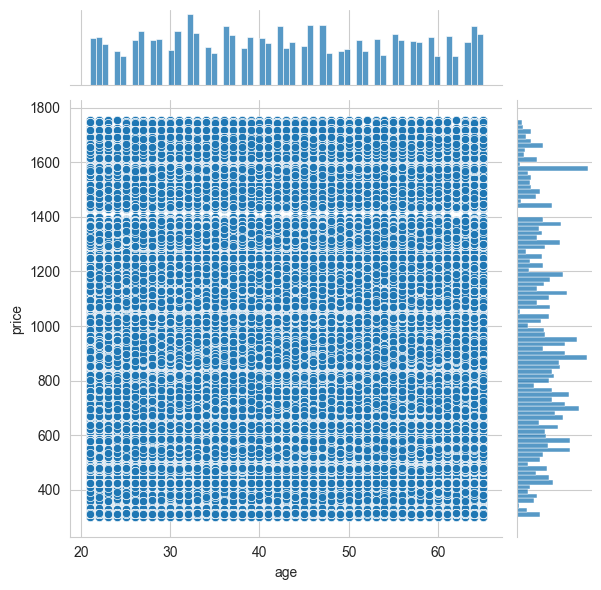

In [24]:
sns.jointplot(
    x='age',
    y='price',
    data=flight_user_df,
)

In [26]:
# train test split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    flight_user_df,
    test_size=0.33,
    random_state=42,
)


In [30]:
df = pd.read_csv("formula1.csv")
df

,Unnamed: 0,name,country,team,races,years_in_f1,championships,gp_wins,podiums,poles,dnfs,fav_circuit,avg_yearly_salary
0,0,Frank Daniels,United States,Mercedes,67,4,5,56,29,62,16,Albert Park,16
1,1,Pierangelo Franceschi,Italy,Aston Martin,218,10,3,75,43,55,9,Circuit Zandvoort,17
2,2,Frederick Gamble,United States,Ferrari,167,8,3,56,52,72,11,Imola,14
3,3,Tristan Rousseau-Grondin,France,AlphaTauri,251,12,4,68,37,70,16,Circuit of The Americas,14
4,4,Horacio Alemany,Spain,Aston Martin,185,9,1,73,37,66,11,Jeddah Corniche Circuit,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,745,Ottone Cuda,Italy,AlphaTauri,193,9,1,84,24,63,15,Red Bull Ring,10
746,746,Leonard Murphy-Wells,Great Britain,Ferrari,133,7,5,70,56,76,12,Suzuka Circuit,16
747,747,Veerle Vos,Netherlands,Ferrari,206,10,2,60,29,58,9,Hungaroring,11
748,748,Pamela White,Great Britain,Haas,166,8,5,52,38,69,13,Circuit Zandvoort,11


In [32]:
from sklearn.linear_model import LinearRegression

X = df.iloc[:, 4:11]
Y = df['avg_yearly_salary']

In [36]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.33, random_state=0)
lr = LinearRegression()
lr.fit(train_x, train_y)

lr.score(test_x, test_y), lr.score(train_x, train_y)

(0.5482134275586212, 0.6600208406486461)

In [37]:
# lasso regression
from sklearn.linear_model import Lasso

ls = Lasso()
ls.fit(train_x, train_y)
ls.score(test_x, test_y), ls.score(train_x, train_y)

(0.42755686698688633, 0.524668619221955)

In [38]:
# ridge regression
from sklearn.linear_model import Ridge

rd = Ridge()
rd.fit(train_x, train_y)
rd.score(test_x, test_y), rd.score(train_x, train_y)

(0.5482375847467247, 0.6600204087771455)

In [41]:
test_x.iloc[0]

races            152
years_in_f1        7
championships      4
gp_wins           64
podiums           44
poles             69
dnfs              17
Name: 474, dtype: int64

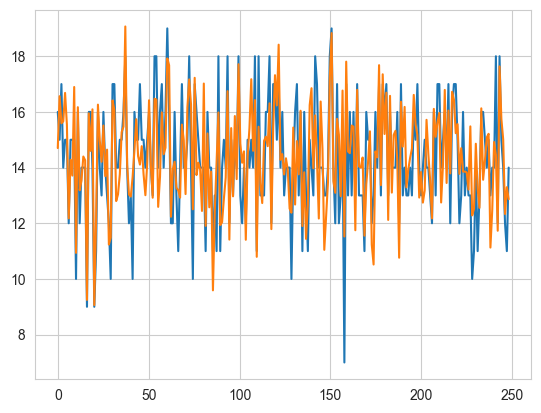

In [44]:
# plot prediction
x = np.linspace(0, len(test_x), len(test_x))
plt.plot(x, test_y, label='actual')
plt.plot(x, lr.predict(test_x), label='linear')

In [1]:
import requests

In [4]:
print(
requests.post('http://127.0.0.1:5000/login', {
    'username': 'admin',
    'password': 'admin',
}).text)

<!doctype html>
<html lang=en>
  <head>
    <title>sqlalchemy.exc.InvalidRequestError: One or more mappers failed to initialize - can't proceed with initialization of other mappers. Triggering mapper: 'mapped class User->users'. Original exception was: Could not determine join condition between parent/child tables on relationship User.timeline - there are no foreign keys linking these tables.  Ensure that referencing columns are associated with a ForeignKey or ForeignKeyConstraint, or specify a 'primaryjoin' expression.
 // Werkzeug Debugger</title>
    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css">
    <link rel="shortcut icon"
        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">
    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>
    <script>
      var CONSOLE_MODE = false,
          EVALEX = true,
          EVALEX_TRUSTED = false,
          SECRET = "TOTllhcSekZzGNnfAf0O";
    </script>
  </head>
  <body